# Fig 7: TCGA and Joung-MORF Analyses

- TCGA isoform abundance analysis
- Joung re-analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import os
import seaborn as sns
import sys
import upsetplot

from adjustText import adjust_text
from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import statsmodels.stats.multitest as smt
from upsetplot import plot

# import utils
sys.path.append("../")
sys.path.append("../data_loading")

import plotting
from plotting import (PAPER_PRESET, PAPER_FONTSIZE, 
                      nice_boxplot, mimic_r_boxplot, annotate_pval, 
                      y2h_ppi_per_tf_gene_plot)

from data_loading import (load_annotated_TFiso1_collection,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped,
                          load_ref_vs_alt_isoforms_table,
                          load_y2h_isoform_data,
                          load_ppi_partner_categories)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)

## variables

In [5]:
dn_pal = {"ref": sns.color_palette("Set2")[0],
          "similar to ref.": sns.color_palette("Set2")[0],
          "rewirer": sns.color_palette("Set2")[2],
          "negative regulator": sns.color_palette("Set2")[1],
          "NA": "lightgray",
          "likely non-functional": "darkgray"}

In [6]:
dn_f = "../../supp/SuppTable_NegRegs.txt"

In [7]:
hnscc_cnts_f = "../../data/processed/Nathans_analysis/HNSCC/isoCounts.TFIso-HNSCC.txt"
hnscc_tx_f = "../../data/processed/Nathans_analysis/HNSCC/transcript.TFIso-HNSCC.txt"

In [8]:
luad_cnts_f = "../../data/processed/Nathans_analysis/LUAD/isoCounts.TFIso-Lung.txt"
luad_tx_f = "../../data/processed/Nathans_analysis/LUAD/transcript.TFIso-Lung.txt"

In [9]:
brca_cnts_f = "../../data/processed/Nathans_analysis/Breast_cancer/isoCounts.BreastCancer.txt"
brca_tx_f = "../../data/processed/Nathans_analysis/Breast_cancer/transcript.BreastCancer.txt"

In [10]:
oncots_f = "../../data/processed/Nathans_analysis/Joung_Reanalysis/DEGs-metacell/Ensembl-OnogeneTS.txt"

In [11]:
deg_dir = "../../data/processed/Nathans_analysis/Joung_Reanalysis/DEGs-metacell"
joung_map_f = "../../data/internal/Joung_TF1p0_Map.txt"
tf_tgts_f = "../../data/processed/Nathans_analysis/Joung_Reanalysis/DEGs-metacell/Ensembl-TFTargets.txt"
joung_tx_preds_f = "../../data/processed/Nathans_analysis/Joung_Reanalysis/DEGs-metacell/Oncogene-TS_Alt-Ref.xlsx"

## 1. import data

In [12]:
dn = pd.read_table(dn_f)

In [13]:
hnscc = pd.read_table(hnscc_tx_f, sep="\t")
hnscc.shape

(99922, 547)

In [14]:
luad = pd.read_table(luad_tx_f, sep="\t")
luad.shape

(99922, 1147)

In [15]:
# some malformed rows in brca - none of these genes matter so skipping
skiprows=list(range(96320, 96387))+list(range(99680,99687))
brca = pd.read_table(brca_tx_f, sep="\t", skiprows=skiprows)
brca.shape

(99774, 1223)

In [16]:
oncots = pd.read_table(oncots_f, sep="\t")
len(oncots)

2227

In [17]:
joung_map = pd.read_table(joung_map_f)

In [18]:
tf_tgts = pd.read_table(tf_tgts_f)

In [19]:
grns_down = pd.read_excel(joung_tx_preds_f, sheet_name="down")
grns_up = pd.read_excel(joung_tx_preds_f, sheet_name="up")

## 2. get paired samples for HNSCC + LUAD + BRCA (from same patient)

In [20]:
paired_dfs = {}

for tcga, cancer_type in zip([hnscc, luad, brca], ["HNSCC", "LUAD", "BRCA"]):
    print(cancer_type)
    
    cols = [x for x in tcga.columns if x != "UID"]
    
    # only use primary tumor samples (ignore metastases)
    cancer_samps = [x for x in cols if "-01A" in x or "-01B" in x]
    ctrl_samps = [x for x in cols if "-11A" in x or "-11B" in x]
    
    # make a dataframe to pair the samps
    cancer_samps_df = pd.DataFrame({"tcga_id": cancer_samps, "type": ["tumor"] * len(cancer_samps)})
    ctrls_samps_df = pd.DataFrame({"tcga_id": ctrl_samps, "type": ["control"] * len(ctrl_samps)})

    cancer_samps_df["patient_id"] = cancer_samps_df["tcga_id"].str.split("-", expand=True)[2]
    ctrls_samps_df["patient_id"] = ctrls_samps_df["tcga_id"].str.split("-", expand=True)[2]

    paired_df = ctrls_samps_df.merge(cancer_samps_df, on=["patient_id"], suffixes=("_ctrl", "_tumor"))
    print(len(paired_df))
    
    # de-dupe if necessary
    paired_df = paired_df.drop_duplicates(subset="patient_id")
    print(len(paired_df))
    
    paired_dfs[cancer_type] = paired_df

HNSCC
43
43
LUAD
116
105
BRCA
116
112


## 3. read in TFs + make annot map

In [21]:
tfs = load_annotated_TFiso1_collection()

reading from cache


In [22]:
data = [
    (tf, iso.name, getattr(iso, 'clone_acc', 'none'), enst_id if enst_id else 'none')
    for tf, db in tfs.items()
    for iso in db.isoforms
    for enst_id in (iso.ensembl_transcript_ids if iso.ensembl_transcript_ids else [None])
]

tf_id_map = pd.DataFrame(data, columns=["gene_name", "iso_id", "clone_acc", "enst_id"])

print(len(tf_id_map))
tf_id_map.sample(5)

1447


,gene_name,iso_id,clone_acc,enst_id
921,NR2F2,NR2F2-2,NR2F2|2/2|09C09,ENST00000453270
301,ZNF131,ZNF131-2,ZNF131|2/5|02A07,ENST00000509156
435,DMTF1,DMTF1-3,DMTF1|3/5|05B01,none
463,ZNF655,ZNF655-213,none,ENST00000454654
663,MXI1,MXI1-3,MXI1|3/4|01H03,ENST00000651516


In [23]:
def merge_id(row):
    if row.enst_id == "none":
        return row.clone_acc
    else:
        return row.enst_id
    
tf_id_map["merge_id"] = tf_id_map.apply(merge_id, axis=1)

In [24]:
dd = tf_id_map[["iso_id", "gene_name"]].drop_duplicates()
print(len(dd))
gene_dict = {row.iso_id : row.gene_name for i, row in dd.iterrows()}

1197


## 4. calculate differential isoform usage (between tumor/ctrl)

In [25]:
# rename columns
def rename_col(row):
    if row.UID in list(tf_id_map["clone_acc"]):
        return row.UID
    else:
        return row.UID.split("|")[0].split(".")[0]

In [26]:
## calculate p-value using wilcoxon
def paired_pval(row, ctrl_cols, tumor_cols):
    x = row[ctrl_cols]
    y = row[tumor_cols]
    
    # make sure x, y are filtered for nan while maintaining pair relationship
    x_filt = []
    y_filt = []
    for x_, y_ in zip(x, y):
        if pd.isnull(x_) or pd.isnull(y_):
            continue
        else:
            x_filt.append(x_)
            y_filt.append(y_)

    try:
        stat, p = wilcoxon(x_filt, y_filt)
        return p
    except:
        return np.nan
    
## return number of samps that went into p-val calc
def paired_samps(row, ctrl_cols, tumor_cols):
    x = row[ctrl_cols]
    y = row[tumor_cols]
    
    # make sure x, y are filtered for nan while maintaining pair relationship
    x_filt = []
    y_filt = []
    for x_, y_ in zip(x, y):
        if pd.isnull(x_) or pd.isnull(y_):
            continue
        else:
            x_filt.append(x_)
            y_filt.append(y_)

    return len(x_filt)

In [27]:
res_dfs = {}
tpm_dfs = {}
gene_dfs = {}

for tcga, cancer_type in zip([hnscc, luad, brca], ["HNSCC", "LUAD", "BRCA"]):
    print(cancer_type)
    
    # rename col so we can merge
    tcga_cols = [x for x in tcga.columns if x != "UID"]
    tcga["UID"] = tcga.apply(rename_col, axis=1)
    tcga = tcga.merge(tf_id_map, left_on="UID", right_on="merge_id")
    tcga_isos = tcga.groupby("iso_id")[tcga_cols].agg("sum").reset_index()
    
    # calculate isoform ratios
    tcga_genes = pd.Series(index=tcga_isos.iso_id, data=tcga_isos.iso_id.map(gene_dict).values)

    tcga_idx = tcga_isos.set_index("iso_id", inplace=False)
    tcga_idx = tcga_idx[tcga_cols]
    tcga_gene_sum = tcga_idx.groupby(tcga_genes).transform('sum')

    f_tcga = tcga_idx/tcga_gene_sum

    # set anything w gene-level exp <= 1 to nan
    f_tcga = f_tcga * (tcga_gene_sum >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])
    
    paired_df = paired_dfs[cancer_type]
    paired_ctrls = list(paired_df["tcga_id_ctrl"])
    paired_tumors = list(paired_df["tcga_id_tumor"])
    
    tcga_isos["mean_paired-%s_tpm" % cancer_type] = tcga_isos[paired_tumors].mean(axis=1)
    tcga_isos["mean_paired-ctrls_tpm"] = tcga_isos[paired_ctrls].median(axis=1)
    
    tcga_gene_sum["mean_paired-%s_tpm" % cancer_type] = tcga_gene_sum[paired_tumors].mean(axis=1)
    tcga_gene_sum["mean_paired-ctrls_tpm"] = tcga_gene_sum[paired_ctrls].median(axis=1)
    
    f_tcga["mean_paired-%s_ratio" % cancer_type] = f_tcga[paired_tumors].mean(axis=1)
    f_tcga["mean_paired-ctrls_ratio"] = f_tcga[paired_ctrls].median(axis=1)
    
    f_tcga["wilcox_pval"] = f_tcga.apply(paired_pval, ctrl_cols=paired_ctrls, tumor_cols=paired_tumors, axis=1)
    f_tcga["wilcox_n_samps"] = f_tcga.apply(paired_samps, ctrl_cols=paired_ctrls, tumor_cols=paired_tumors, axis=1)
    print(len(f_tcga))

    # filter anything out with < 20 samps
    f_tcga_filt = f_tcga[(~pd.isnull(f_tcga["wilcox_pval"])) & (f_tcga["wilcox_n_samps"] >= 20)]
    
    # filter to the same isos in tpm df
    tcga_isos_filt = tcga_isos[tcga_isos["iso_id"].isin(f_tcga_filt.index)]
    tcga_gene_sum_filt = tcga_gene_sum[tcga_gene_sum.index.isin(f_tcga_filt.index)]
    print(len(f_tcga_filt))
    print(len(tcga_isos_filt))

    f_tcga_filt["wilcox_padj"] = smt.multipletests(list(f_tcga_filt["wilcox_pval"]), alpha=0.05, method="fdr_bh")[1]
    
    for i, row in paired_df.iterrows():
        f_tcga_filt["paired-diff_%s_ratio" % (i+1)] = f_tcga_filt[row.tcga_id_tumor]-f_tcga_filt[row.tcga_id_ctrl]
        tcga_isos_filt["paired-l2fc_%s_tpm" % (i+1)] = np.log2((tcga_isos_filt[row.tcga_id_tumor]+1)/(tcga_isos_filt[row.tcga_id_ctrl]+1))
        tcga_gene_sum_filt["paired-l2fc_%s_tpm" % (i+1)] = np.log2((tcga_gene_sum_filt[row.tcga_id_tumor]+1)/(tcga_gene_sum_filt[row.tcga_id_ctrl]+1))
    
    print(len(f_tcga_filt[f_tcga_filt["wilcox_padj"] < 0.05]))
    
    paired_cols = [x for x in f_tcga_filt.columns if x.startswith("paired")]
    f_tcga_filt["mean_paired-diff_ratio"] = f_tcga_filt[paired_cols].mean(axis=1)
    paired_cols = [x for x in tcga_isos_filt.columns if x.startswith("paired")]
    tcga_isos_filt["mean_paired-l2fc_tpm"] = tcga_isos_filt[paired_cols].mean(axis=1)
    paired_cols = [x for x in tcga_gene_sum_filt.columns if x.startswith("paired")]
    tcga_gene_sum_filt["mean_paired-l2fc_tpm"] = tcga_gene_sum_filt[paired_cols].mean(axis=1)

    res_dfs[cancer_type] = f_tcga_filt
    tpm_dfs[cancer_type] = tcga_isos_filt
    gene_dfs[cancer_type] = tcga_gene_sum_filt

HNSCC
1197
826
826
99
LUAD
1197
1000
1000
373
BRCA
1197
1043
1043
336


## 5. merge all TCGA analyses with DN categories

In [28]:
# first iso-ratio dfs
brca_iso = res_dfs["BRCA"].reset_index()
luad_iso = res_dfs["LUAD"].reset_index()
hnscc_iso = res_dfs["HNSCC"].reset_index()

brca_iso = brca_iso[["iso_id", "mean_paired-BRCA_ratio", "mean_paired-ctrls_ratio", "mean_paired-diff_ratio",
                     "wilcox_pval", "wilcox_n_samps", "wilcox_padj"]]
brca_iso.columns = ["isoform", "mean_tumor_iso_pct_brca", "mean_normal_iso_pct_brca", "mean_iso_pct_diff_brca",
                    "pval_brca", "n_samps_brca", "padj_brca"]

luad_iso = luad_iso[["iso_id", "mean_paired-LUAD_ratio", "mean_paired-ctrls_ratio", "mean_paired-diff_ratio",
                     "wilcox_pval", "wilcox_n_samps", "wilcox_padj"]]
luad_iso.columns = ["isoform", "mean_tumor_iso_pct_luad", "mean_normal_iso_pct_luad", "mean_iso_pct_diff_luad",
                    "pval_luad", "n_samps_luad", "padj_luad"]

hnscc_iso = hnscc_iso[["iso_id", "mean_paired-HNSCC_ratio", "mean_paired-ctrls_ratio", "mean_paired-diff_ratio",
                       "wilcox_pval", "wilcox_n_samps", "wilcox_padj"]]
hnscc_iso.columns = ["isoform", "mean_tumor_iso_pct_hnscc", "mean_normal_iso_pct_hnscc", 
                     "mean_iso_pct_diff_hnscc", "pval_hnscc", "n_samps_hnscc", "padj_hnscc"]

print(len(brca_iso))
print(len(luad_iso))
print(len(hnscc_iso))

1043
1000
826


In [29]:
# then tpm dfs
brca_tpm = tpm_dfs["BRCA"].reset_index()
luad_tpm = tpm_dfs["LUAD"].reset_index()
hnscc_tpm = tpm_dfs["HNSCC"].reset_index()

brca_tpm = brca_tpm[["iso_id", "mean_paired-BRCA_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
brca_tpm.columns = ["isoform", "mean_tumor_iso_tpm_brca", "mean_normal_iso_tpm_brca", "mean_iso_l2fc_brca"]

luad_tpm = luad_tpm[["iso_id", "mean_paired-LUAD_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
luad_tpm.columns = ["isoform", "mean_tumor_iso_tpm_luad", "mean_normal_iso_tpm_luad", "mean_iso_l2fc_luad"]

hnscc_tpm = hnscc_tpm[["iso_id", "mean_paired-HNSCC_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
hnscc_tpm.columns = ["isoform", "mean_tumor_iso_tpm_hnscc", "mean_normal_iso_tpm_hnscc", "mean_iso_l2fc_hnscc"]

print(len(brca_tpm))
print(len(luad_tpm))
print(len(hnscc_tpm))

1043
1000
826


In [30]:
# then gene dfs
brca_gene = gene_dfs["BRCA"].reset_index()
luad_gene = gene_dfs["LUAD"].reset_index()
hnscc_gene = gene_dfs["HNSCC"].reset_index()

brca_gene = brca_gene[["iso_id", "mean_paired-BRCA_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
brca_gene.columns = ["isoform", "mean_tumor_gene_tpm_brca", "mean_normal_gene_tpm_brca", "mean_gene_l2fc_brca"]

luad_gene = luad_gene[["iso_id", "mean_paired-LUAD_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
luad_gene.columns = ["isoform", "mean_tumor_gene_tpm_luad", "mean_normal_gene_tpm_luad", "mean_gene_l2fc_luad"]

hnscc_gene = hnscc_gene[["iso_id", "mean_paired-HNSCC_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
hnscc_gene.columns = ["isoform", "mean_tumor_gene_tpm_hnscc", "mean_normal_gene_tpm_hnscc", "mean_gene_l2fc_hnscc"]

print(len(brca_gene))
print(len(luad_gene))
print(len(hnscc_gene))

1043
1000
826


In [31]:
pancan_iso = brca_iso.merge(luad_iso, on="isoform", how="outer").merge(hnscc_iso, on="isoform", how="outer")
print(len(pancan_iso))
pancan_tpm = brca_tpm.merge(luad_tpm, on="isoform", how="outer").merge(hnscc_tpm, on="isoform", how="outer")
print(len(pancan_tpm))
pancan_gene = brca_gene.merge(luad_gene, on="isoform", how="outer").merge(hnscc_gene, on="isoform", how="outer")
print(len(pancan_gene))
pancan_tpm = pancan_tpm.merge(pancan_gene, on="isoform", how="outer", suffixes=("_iso", "_gene"))
pancan = pancan_iso.merge(pancan_tpm, on="isoform", how="outer")
print(len(pancan))

1074
1074
1074
1074


In [32]:
pancan = pancan.merge(tf_id_map[["iso_id", "clone_acc", "gene_name"]].drop_duplicates(), 
                      left_on="isoform", right_on="iso_id").drop_duplicates()
print(len(pancan))

1074


In [33]:
oncots_mrg = oncots.groupby("UID")["Group"].agg(list).reset_index()

# fix the excel date issues
def fix_excel_date(row):
    if row.UID == "1-Dec":
        return "DEC1"
    elif row.UID == "4-Sep":
        return "SEPT4"
    elif row.UID == "9-Sep":
        return "SEPT9"
    else:
        return row.UID

oncots_mrg["gene_name"] = oncots_mrg.apply(fix_excel_date, axis=1)

# categorize as oncogene/tumor suppressor
def categorize_onco_ts(row):
    if "Oncogene" in row["Group"] and "Tumor Suppressor" not in row["Group"]:
        return "Oncogene"
    elif "Tumor Suppressor" in row["Group"] and "Oncogene" not in row["Group"]:
        return "Tumor Suppressor"
    else:
        return "Cancer-associated"
    
oncots_mrg["cancer_status"] = oncots_mrg.apply(categorize_onco_ts, axis=1)
oncots_mrg.cancer_status.value_counts()

cancer_status
Tumor Suppressor     1084
Oncogene              668
Cancer-associated     129
Name: count, dtype: int64

In [34]:
pancan = pancan.merge(oncots_mrg[["gene_name", "cancer_status"]], on="gene_name", how="left")
pancan["cancer_status"] = pancan["cancer_status"].fillna("none")
pancan.cancer_status.value_counts()

cancer_status
none                 732
Tumor Suppressor     211
Oncogene              89
Cancer-associated     42
Name: count, dtype: int64

In [35]:
def sig_status(row):
    if row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in all 3"
    elif row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05:
        return "sig. in BRCA + LUAD"
    elif row["padj_brca"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in BRCA + HNSCC"
    elif row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in LUAD + HNSCC"
    elif row["padj_brca"] < 0.05:
        return "sig. in BRCA"
    elif row["padj_luad"] < 0.05:
        return "sig. in LUAD"
    elif row["padj_hnscc"] < 0.05:
        return "sig. in HNSCC"
    else:
        return "not sig. in any"
    
def sig_status_simple(row):
    if row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_brca"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_brca"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_luad"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_hnscc"] < 0.05:
        return "sig. in ≥1"
    else:
        return "not sig. in any"
    
def directionality(row):
    if row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        if row["mean_iso_pct_diff_brca"] < 0 and row["mean_iso_pct_diff_luad"] < 0 and row["mean_iso_pct_diff_hnscc"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_brca"] > 0 and row["mean_iso_pct_diff_luad"] > 0 and row["mean_iso_pct_diff_hnscc"] > 0:
            return "up in tumors"
        else:
            return "combination"
    elif row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05:
        if row["mean_iso_pct_diff_brca"] < 0 and row["mean_iso_pct_diff_luad"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_brca"] > 0 and row["mean_iso_pct_diff_luad"] > 0:
            return "up in tumors"
        else:
            return "combination"
    elif row["padj_brca"] < 0.05 and row["padj_hnscc"] < 0.05:
        if row["mean_iso_pct_diff_brca"] < 0 and row["mean_iso_pct_diff_hnscc"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_brca"] > 0 and row["mean_iso_pct_diff_hnscc"] > 0:
            return "up in tumors"
        else:
            return "combination"
    elif row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        if row["mean_iso_pct_diff_luad"] < 0 and row["mean_iso_pct_diff_hnscc"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_luad"] > 0 and row["mean_iso_pct_diff_hnscc"] > 0:
            return "up in tumors"
        else:
            return "combination"
    elif row["padj_brca"] < 0.05:
        if row["mean_iso_pct_diff_brca"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_brca"] > 0:
            return "up in tumors"
    elif row["padj_luad"] < 0.05:
        if row["mean_iso_pct_diff_luad"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_luad"] > 0:
            return "up in tumors"
    elif row["padj_hnscc"] < 0.05:
        if row["mean_iso_pct_diff_hnscc"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_hnscc"] > 0:
            return "up in tumors"
    else:
        return "not sig. in any"

pancan["sig_status"] = pancan.apply(sig_status, axis=1)
pancan["sig_status_simple"] = pancan.apply(sig_status_simple, axis=1)
pancan["directionality"] = pancan.apply(directionality, axis=1)
pancan.directionality.value_counts()

directionality
not sig. in any    529
up in tumors       261
down in tumors     247
combination         37
Name: count, dtype: int64

In [36]:
dn_melt = dn[["gene_symbol", "reference_isoform"]]
dn_melt.columns = ["gene_symbol", "isoform"]
dn_melt["dn_cat"] = "ref"
dn_melt2 = dn[["gene_symbol", "alternative_isoform", "alt_iso_classification"]]
dn_melt2.columns = ["gene_symbol", "isoform", "dn_cat"]
dn_melt = pd.concat([dn_melt, dn_melt2], ignore_index=True)
dn_melt.fillna("NA", inplace=True)
dn_melt.dn_cat.value_counts()

dn_cat
ref                      447
NA                       272
negative regulator       102
rewirer                   57
similar to ref.           15
likely non-functional      1
Name: count, dtype: int64

In [37]:
pancan = pancan.merge(dn_melt, on="isoform", how="left").drop_duplicates()
len(pancan)
pancan.dn_cat.value_counts()

dn_cat
NA                       238
ref                      218
negative regulator        93
rewirer                   48
similar to ref.           15
likely non-functional      1
Name: count, dtype: int64

In [38]:
pancan_lib = pancan[~pd.isnull(pancan["dn_cat"])]
print(len(pancan_lib))

613


## 6. plot significant isoforms across cancers

In [39]:
brca_sig = set(pancan[pancan['padj_brca'] < 0.05]['isoform'])
print(len(brca_sig))
luad_sig = set(pancan[pancan['padj_luad'] < 0.05]['isoform'])
print(len(luad_sig))
hnscc_sig = set(pancan[pancan['padj_hnscc'] < 0.05]['isoform'])
print(len(hnscc_sig))

336
373
99


545


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


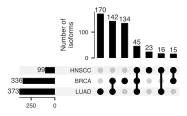

In [40]:
contents = {"BRCA": brca_sig, "LUAD": luad_sig, "HNSCC": hnscc_sig}
contents = upsetplot.from_contents(contents)

all_sig = set(brca_sig).union(set(luad_sig)).union(set(hnscc_sig))
print(len(all_sig))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=16, 
     intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("Number of\nisoforms")
d["intersections"].grid(False)
d["totals"].grid(False)
fig.savefig("../../figures/fig7/PanCan_UpSetPlot.pdf", dpi="figure", bbox_inches="tight")

In [41]:
brca_sig = set(pancan_lib[pancan_lib['padj_brca'] < 0.05]['isoform'])
print(len(brca_sig))
luad_sig = set(pancan_lib[pancan_lib['padj_luad'] < 0.05]['isoform'])
print(len(luad_sig))
hnscc_sig = set(pancan_lib[pancan_lib['padj_hnscc'] < 0.05]['isoform'])
print(len(hnscc_sig))

190
216
63


314


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


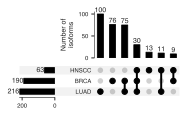

In [42]:
contents = {"BRCA": brca_sig, "LUAD": luad_sig, "HNSCC": hnscc_sig}
contents = upsetplot.from_contents(contents)

all_sig = set(brca_sig).union(set(luad_sig)).union(set(hnscc_sig))
print(len(all_sig))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=16, 
     intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("Number of\nisoforms")
d["intersections"].grid(False)
d["totals"].grid(False)
fig.savefig("../../figures/fig7/PanCan_UpSetPlot.TF1p0_Only.pdf", dpi="figure", bbox_inches="tight")

395
289
[]


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


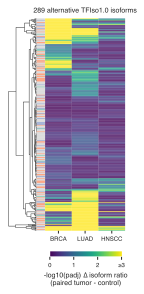

In [43]:
pc_hm = pancan_lib[pancan_lib["dn_cat"] != "ref"][["isoform", "padj_brca", "padj_luad", "padj_hnscc",
                "dn_cat"]].set_index("isoform")

print(len(pc_hm))
pc_hm = pc_hm.dropna()
print(len(pc_hm))

# lut = {"none": "lightgrey",
#        "oncogene": sns.color_palette("Set2")[1],
#        "tumor suppressor": sns.color_palette("Set2")[0],
#        "cancer-associated": sns.color_palette("Set2")[2]}
row_colors = pc_hm.dn_cat.map(dn_pal)
pc_hm.drop("dn_cat", axis=1, inplace=True)
pc_hm = -np.log10(pc_hm)

g = sns.clustermap(data=pc_hm, cmap="viridis", linewidth=0, figsize=(2, 3.5), yticklabels=False,
               xticklabels=['BRCA', 'LUAD', 'HNSCC'], vmax=3, dendrogram_ratio=(0.25, 0),
               metric='euclidean', method='complete', col_cluster=False, col_linkage=None,
               cbar_pos=(0.35, 0.02, 0.5, 0.02), cbar_kws={"label": "-log10(padj) ∆ isoform ratio\n(paired tumor - control)",
                                                    "ticks": [0, 1, 2, 3],
                                                          "orientation": "horizontal"},
                   row_colors=row_colors, colors_ratio=0.07)
_ = g.cax.set_xticklabels([0, 1, 2, "≥3"])
g.ax_row_colors.set_xticklabels('')
g.ax_row_colors.set_xticks([])
g.ax_heatmap.set_title('%s alternative TFIso1.0 isoforms' % (len(pc_hm)), fontsize=PAPER_FONTSIZE)
g.ax_heatmap.set_ylabel('')


# label specific genes
pc_hm = pancan_lib[(pancan_lib["dn_cat"] != "ref")][["isoform", "padj_brca", "padj_luad", "padj_hnscc",
                "cancer_status"]].set_index("isoform")
pc_hm["min_padj"] = pc_hm[["padj_brca", "padj_luad", "padj_hnscc"]].min(axis=1)
use_labels = list(pc_hm[(pc_hm["cancer_status"].isin(["oncogene", "tumor suppressor"])) &
                        (pc_hm["min_padj"] < 0.05)].index)
reordered_labels = pc_hm.index[g.dendrogram_row.reordered_ind].tolist()
use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
g.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels)

# print the labels to make more clear in illustrator
idx = np.argsort(use_ticks)
print(np.asarray(use_labels)[idx])



g.savefig("../../figures/fig7/PanCan_Heatmap.Alt_Only.pdf", dpi="figure", bbox_inches="tight")

In [44]:
nonan = pancan_lib[(~pd.isnull(pancan_lib['mean_iso_pct_diff_brca'])) &
                   (~pd.isnull(pancan_lib['mean_iso_pct_diff_luad'])) &
                   (~pd.isnull(pancan_lib['mean_iso_pct_diff_hnscc']))]

tots = pd.DataFrame(nonan[nonan["sig_status"] == "not sig. in any"].dn_cat.value_counts())
sig = pd.DataFrame(nonan[nonan["sig_status"] != "not sig. in any"].dn_cat.value_counts())

st = tots.join(sig, lsuffix="_not_sig", rsuffix="_sig")
st = st.loc[["negative regulator", "rewirer", "similar to ref.", "NA"]]
st = st/st.sum(axis=0)
st.columns = ['count_not_sig', 'count_sig']
st

,count_not_sig,count_sig
dn_cat,,
negative regulator,0.202899,0.333333
rewirer,0.152174,0.106667
similar to ref.,0.036232,0.046667
NA,0.608696,0.513333


In [45]:
tots

,count
dn_cat,
NA,84
ref,50
negative regulator,28
rewirer,21
similar to ref.,5


In [46]:
nonan[nonan["sig_status"] == "not sig. in any"].dn_cat.value_counts()

dn_cat
NA                    84
ref                   50
negative regulator    28
rewirer               21
similar to ref.        5
Name: count, dtype: int64

In [47]:
fe = np.zeros((2, 2))

alts = nonan[nonan["dn_cat"].isin(["negative regulator", "rewirer", "similar to ref.", "NA"])]

fe[0, 0] = len(alts[(alts["dn_cat"] == "negative regulator") & 
                    (alts["sig_status"] != "not sig. in any")].isoform.unique())
fe[1, 0] = len(alts[(alts["dn_cat"] != "negative regulator") & 
                    (alts["sig_status"] != "not sig. in any")].isoform.unique())
fe[0, 1] = len(alts[(alts["dn_cat"] == "negative regulator") & 
                    (alts["sig_status"] == "not sig. in any")].isoform.unique())
fe[1, 1] = len(alts[(alts["dn_cat"] != "negative regulator") & 
                    (alts["sig_status"] == "not sig. in any")].isoform.unique())
print(fisher_exact(fe))
p = fisher_exact(fe)[1]

SignificanceResult(statistic=1.9642857142857142, pvalue=0.01664144739098477)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


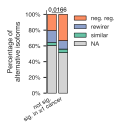

In [48]:
fig, ax = plt.subplots(figsize=(0.4, 1.5))

xs = ["not sig.", "sig. in ≥1 cancer"]
y1 = list(st[["count_not_sig", "count_sig"]].loc["NA"])
y2 = list(st[["count_not_sig", "count_sig"]].loc["similar to ref."])
b2 = np.add(y1, y2)
y3 = list(st[["count_not_sig", "count_sig"]].loc["rewirer"])
b3 = np.add(b2, y3)
y4 = list(st[["count_not_sig", "count_sig"]].loc["negative regulator"])

ax.bar(xs, y1, color=dn_pal["NA"], label="NA", edgecolor="black", linewidth=0.5)
ax.bar(xs, y2, bottom=y1, color=dn_pal["similar to ref."], label="similar", edgecolor="black", linewidth=0.5)
ax.bar(xs, y3, bottom=b2, color=dn_pal["rewirer"], label="rewirer", edgecolor="black", linewidth=0.5)
ax.bar(xs, y4, bottom=b3, color=dn_pal["negative regulator"], label="neg. reg.", edgecolor="black", linewidth=0.5)

# annotate pval
annotate_pval(ax, 0, 1, 1.02, 0, 1.02, p, fontsize-1)

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("Percentage of\nalternative isoforms")
ax.set_xticklabels(xs, rotation=30, ha="right", va="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["%s%%" % x for x in [0, 20, 40, 60, 80, 100]])
ax.set_ylim(0, 1.05)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

fig.savefig("../../figures/fig7/PanCan_DN_Stacked.pdf", dpi="figure", bbox_inches="tight")

In [49]:
tots = pd.DataFrame(nonan[nonan["cancer_status"] == "none"].dn_cat.value_counts())
onc = pd.DataFrame(nonan[nonan["cancer_status"] == "Oncogene"].dn_cat.value_counts())
ts = pd.DataFrame(nonan[nonan["cancer_status"] == "Tumor Suppressor"].dn_cat.value_counts())
other = pd.DataFrame(nonan[nonan["cancer_status"].isin(["Cancer-associated"])].dn_cat.value_counts())

st = tots.join(onc, lsuffix="_none", rsuffix="_onc")
st2 = ts.join(other, lsuffix="_ts", rsuffix="_other")
st = st.join(st2)
st = st.loc[["negative regulator", "rewirer", "similar to ref.", "NA"]]
st = st/st.sum(axis=0)
st.fillna(0, inplace=True)
st

,count_none,count_onc,count_ts,count_other
dn_cat,,,,
negative regulator,0.256039,0.473684,0.215686,0.454545
rewirer,0.115942,0.052632,0.215686,0.090909
similar to ref.,0.043478,0.000000,0.039216,0.090909
NA,0.584541,0.473684,0.529412,0.363636


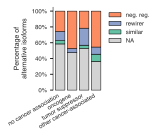

In [50]:
fig, ax = plt.subplots(figsize=(0.9, 1.5))

xs = ["no cancer association", "oncogene", "tumor suppressor", "other cancer-associated"]
y1 = list(st[["count_none", "count_onc", "count_ts", "count_other"]].loc["NA"])
y2 = list(st[["count_none", "count_onc", "count_ts", "count_other"]].loc["similar to ref."])
b2 = np.add(y1, y2)
y3 = list(st[["count_none", "count_onc", "count_ts", "count_other"]].loc["rewirer"])
b3 = np.add(b2, y3)
y4 = list(st[["count_none", "count_onc", "count_ts", "count_other"]].loc["negative regulator"])

ax.bar(xs, y1, color=dn_pal["NA"], label="NA", edgecolor="black", linewidth=0.5)
ax.bar(xs, y2, bottom=y1, color=dn_pal["similar to ref."], label="similar", edgecolor="black", linewidth=0.5)
ax.bar(xs, y3, bottom=b2, color=dn_pal["rewirer"], label="rewirer", edgecolor="black", linewidth=0.5)
ax.bar(xs, y4, bottom=b3, color=dn_pal["negative regulator"], label="neg. reg.", edgecolor="black", linewidth=0.5)


# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("Percentage of\nalternative isoforms")
ax.set_xticklabels(xs, rotation=30, ha="right", va="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["%s%%" % x for x in [0, 20, 40, 60, 80, 100]])
ax.set_ylim(0, 1.05)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

#fig.savefig("../../figures/fig7/PanCan_DN_Stacked.OncoKB.pdf", dpi="figure", bbox_inches="tight")

In [51]:
fe = np.zeros((2, 2))

print(len(nonan))
alts = nonan[nonan["dn_cat"].isin(["negative regulator", "rewirer", "similar to ref.", "NA"])]

fe[0, 0] = len(alts[(alts["dn_cat"] == "negative regulator") & 
                    (alts["cancer_status"].isin(["Oncogene"]))].isoform.unique())
fe[1, 0] = len(alts[(alts["dn_cat"] != "negative regulator") & 
                    (alts["cancer_status"].isin(["Oncogene"]))].isoform.unique())
fe[0, 1] = len(alts[(alts["dn_cat"] == "negative regulator") & 
                    (alts["cancer_status"] == "none")].isoform.unique())
fe[1, 1] = len(alts[(alts["dn_cat"] != "negative regulator") & 
                    (alts["cancer_status"] == "none")].isoform.unique())
print(fisher_exact(fe))
p = fisher_exact(fe)[1]

444
SignificanceResult(statistic=2.6150943396226416, pvalue=0.05808835048998021)


188
151
['PBX1-2' 'SMAD3-3' 'NR4A1-1' 'PATZ1-2' 'PATZ1-3' 'MAX-5' 'NR4A1-4'
 'PKNOX1-3' 'TCF4-8' 'TFCP2-3' 'MEIS1-2' 'HHEX-2' 'CREB1-1']


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


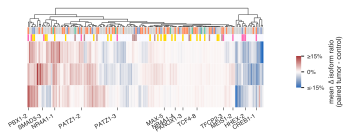

In [52]:
pc_hm = pancan_lib[(pancan_lib["dn_cat"] != "ref") &
                   (pancan_lib["sig_status_simple"] == "sig. in ≥1")][["isoform", "mean_iso_pct_diff_brca", 
                                                                       "mean_iso_pct_diff_luad", 
                                                                       "mean_iso_pct_diff_hnscc",
                                                                       "dn_cat",
                                                                       "cancer_status"]].set_index("isoform")

print(len(pc_hm))
pc_hm = pc_hm.dropna()
print(len(pc_hm))


row_colors1 = pc_hm.dn_cat.map(dn_pal)
row_colors2 = pc_hm.cancer_status.map({"Oncogene": "hotpink",
                                       "Tumor Suppressor": "gold",
                                       "Cancer-associated": "rosybrown",
                                       "none": "ghostwhite"})
to_plot = pc_hm.drop(["dn_cat", "cancer_status"], axis=1)

# flip fig so it fits in composite better
to_plot = to_plot.T

g = sns.clustermap(data=to_plot, cmap="vlag", linewidth=0, figsize=(3.5, 1.75), xticklabels=False,
                   yticklabels=False,
                   vmin=-0.15, vmax=0.15, dendrogram_ratio=(0, 0.2),
                   metric='euclidean', method='complete', row_cluster=False, row_linkage=None,
                   cbar_pos=(1.1, 0.3, 0.02, 0.25), 
                   cbar_kws={"label": "mean ∆ isoform ratio\n(paired tumor - control)",
                             "ticks": [-0.15, 0, 0.15],
                             "orientation": "vertical"},
                   col_colors=[row_colors1, row_colors2], colors_ratio=0.07)
_ = g.cax.set_yticklabels(["≤-15%", "0%", "≥15%"])
g.ax_col_colors.set_yticklabels('')
g.ax_col_colors.set_yticks([])
g.ax_col_colors.set_xticks([])
g.ax_heatmap.set_xlabel('')


# label specific genes
use_labels = list(pc_hm[(pc_hm['cancer_status'].isin(["Oncogene", "Tumor Suppressor"])) &
                        (pc_hm['dn_cat'] == 'negative regulator')].index) + ['SMAD3-3']
reordered_labels = pc_hm.index[g.dendrogram_col.reordered_ind].tolist()
use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
g.ax_heatmap.set(xticks=use_ticks, xticklabels=use_labels)
g.ax_heatmap.set_xticklabels(use_labels, rotation=30, va='top', ha='right')
g.ax_heatmap.xaxis.set_tick_params(width=0.5)

# print the labels to make more clear in illustrator
idx = np.argsort(use_ticks)
print(np.asarray(use_labels)[idx])


g.savefig("../../figures/fig7/PanCan_Heatmap.Alt_Only_EffectSize.pdf", dpi="figure", bbox_inches="tight")

## 7. CREB1 vignette

In [53]:
to_plot_brca = res_dfs['BRCA'].reset_index()

paired_ctrls = list(paired_dfs['BRCA']["tcga_id_ctrl"])
paired_tumors = list(paired_dfs['BRCA']["tcga_id_tumor"])
    
brca_isos_paired = to_plot_brca[["iso_id"] + paired_ctrls + paired_tumors]
new_ctrl_cols = ["normal - %s" % (i+1) for i, x in enumerate(paired_ctrls)]
new_tumor_cols = ["tumor - %s" % (i+1) for i, x in enumerate(paired_tumors)]
brca_isos_paired.columns = ["iso_id"] + new_ctrl_cols + new_tumor_cols
brca_isos_paired = brca_isos_paired.merge(pancan[['iso_id', 'gene_name']], on='iso_id')

In [54]:
creb1 = pancan[pancan['gene_name'] == 'CREB1']
creb1

,isoform,mean_tumor_iso_pct_brca,mean_normal_iso_pct_brca,mean_iso_pct_diff_brca,pval_brca,n_samps_brca,padj_brca,mean_tumor_iso_pct_luad,mean_normal_iso_pct_luad,mean_iso_pct_diff_luad,...,mean_gene_l2fc_hnscc,iso_id,clone_acc,gene_name,cancer_status,sig_status,sig_status_simple,directionality,gene_symbol,dn_cat
45,CREB1-1,0.740075,0.802309,-0.055703,9.895687e-10,112.0,2.563960e-08,0.684294,0.79742,-0.101662,...,0.56393,CREB1-1,CREB1|1/2|02E01,CREB1,Oncogene,sig. in all 3,sig. in ≥1,down in tumors,CREB1,negative regulator
46,CREB1-2,0.259925,0.197691,0.055703,9.895687e-10,112.0,2.563960e-08,0.315706,0.20258,0.101662,...,0.56393,CREB1-2,CREB1|2/2|01F12,CREB1,Oncogene,sig. in all 3,sig. in ≥1,up in tumors,CREB1,ref


In [55]:
f_brca_paired_melt = pd.melt(brca_isos_paired, id_vars=["gene_name", "iso_id"])
f_brca_paired_melt["samp"] = f_brca_paired_melt["variable"].str.split(" ", expand=True)[0]

2.5639596600643643e-08


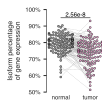

In [56]:
fig = plt.figure(figsize=(1, 1.5))

# plot alt isoform only
tmp = f_brca_paired_melt[f_brca_paired_melt["gene_name"] == "CREB1"]
alt = tmp[tmp["iso_id"] == "CREB1-1"]

ax = sns.swarmplot(data=alt, x="samp", y="value", s=2,
                   palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]},
                   alpha=0.75, linewidth=0.5, edgecolor="black",
                   order=["normal", "tumor"])

norm_paths = ax.collections[0].get_offsets()
norm_x, norm_y = norm_paths[:, 0], norm_paths[:, 1]

tumor_paths = ax.collections[1].get_offsets()
tumor_x, tumor_y = tumor_paths[:, 0], tumor_paths[:, 1]

for i in range(norm_x.shape[0]):
    x = [norm_x[i], tumor_x[i]]
    y = [norm_y[i], tumor_y[i]]
    ax.plot(x, y, linestyle="dashed", color="darkgrey", linewidth=0.25)

# annotate w p-vals
padj = creb1[creb1['iso_id'] == 'CREB1-1']['padj_brca'].iloc[0]
print(padj)
annotate_pval(ax, 0, 1, 0.95, 0, 0.95, padj, fontsize-1)

ax.set_xlabel("")
ax.set_ylim((0.5, 1.))
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels("%s%%" % x for x in [50, 60, 70, 80, 90, 100])
ax.set_ylabel("Isoform percentage\nof gene expression")
#ax.set_title("CREB1 alternative isoform\nin paired BRCA samples")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

#fig.savefig("../../figures/fig7/BRCA_CREB1_swarmplot_paired.pdf", dpi="figure", bbox_inches="tight")

In [57]:
paired_ratio_cols = [x for x in to_plot_brca.columns if x.startswith('paired-diff')]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


82
30
112


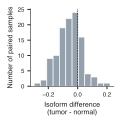

In [58]:
creb1_iso_diff = to_plot_brca[to_plot_brca["iso_id"] == "CREB1-1"][paired_ratio_cols]
creb1_iso_diff = pd.melt(creb1_iso_diff)
creb1_iso_diff = creb1_iso_diff[~pd.isnull(creb1_iso_diff["value"])]

fig = plt.figure(figsize=(1.5, 1.4))
ax = sns.histplot(data=creb1_iso_diff, x="value", color="slategrey")
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
ax.set_xlabel("Isoform difference\n(tumor - normal)")
ax.set_ylabel("Number of paired samples")

print(len(creb1_iso_diff[creb1_iso_diff["value"] < 0]))
print(len(creb1_iso_diff[creb1_iso_diff["value"] > 0]))
print(len(creb1_iso_diff))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/BRCA_CREB1_iso_diff_hist.pdf", dpi="figure", bbox_inches="tight")

In [59]:
to_plot_brca_gene = gene_dfs['BRCA'].reset_index()

brca_genes_paired = to_plot_brca_gene[["iso_id"] + paired_ctrls + paired_tumors]
brca_genes_paired.columns = ["iso_id"] + new_ctrl_cols + new_tumor_cols
brca_genes_paired = brca_genes_paired.merge(pancan[['iso_id', 'gene_name']], on='iso_id')
brca_genes_paired = brca_genes_paired[['gene_name'] + new_ctrl_cols + new_tumor_cols].drop_duplicates()

In [60]:
brca_genes_paired["wilcox_pval"] = brca_genes_paired.apply(paired_pval, ctrl_cols=new_ctrl_cols, tumor_cols=new_tumor_cols, axis=1)
brca_genes_paired["wilcox_n_samps"] = brca_genes_paired.apply(paired_samps, ctrl_cols=new_ctrl_cols, tumor_cols=new_tumor_cols, axis=1)
print(len(brca_genes_paired))

brca_genes_paired_filt = brca_genes_paired[(~pd.isnull(brca_genes_paired["wilcox_pval"])) & (brca_genes_paired["wilcox_n_samps"] >= 20)]
print(len(brca_genes_paired_filt))

brca_genes_paired_filt["wilcox_padj"] = smt.multipletests(list(brca_genes_paired_filt["wilcox_pval"]), alpha=0.05, method="fdr_bh")[1]

212
212


In [61]:
brca_genes_paired_melt = pd.melt(brca_genes_paired_filt, id_vars=["gene_name"])
brca_genes_paired_melt["samp"] = brca_genes_paired_melt["variable"].str.split(" ", expand=True)[0]

0.9121357975374634


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


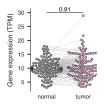

In [62]:
fig = plt.figure(figsize=(1.2, 1.5))

# plot alt isoform only
creb1 = brca_genes_paired_melt[brca_genes_paired_melt["gene_name"] == "CREB1"]

ax = sns.swarmplot(data=creb1, x="samp", y="value", s=2,
                   palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]},
                   alpha=0.75, linewidth=0.5, edgecolor="black",
                   order=["normal", "tumor"])

norm_paths = ax.collections[0].get_offsets()
norm_x, norm_y = norm_paths[:, 0], norm_paths[:, 1]

tumor_paths = ax.collections[1].get_offsets()
tumor_x, tumor_y = tumor_paths[:, 0], tumor_paths[:, 1]

for i in range(norm_x.shape[0]):
    x = [norm_x[i], tumor_x[i]]
    y = [norm_y[i], tumor_y[i]]
    ax.plot(x, y, linestyle="dashed", color="darkgrey", linewidth=0.25)

# annotate w p-vals
padj = brca_genes_paired_filt[brca_genes_paired_filt["gene_name"]== "CREB1"]["wilcox_padj"].iloc[0]
print(padj)
annotate_pval(ax, 0, 1, 30, 0, 30, padj, fontsize-1)

ax.set_xlabel("")
ax.set_ylabel("Gene expression (TPM)")
#ax.set_title("CREB1 alternative isoform\nin paired BRCA samples")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

fig.savefig("../../figures/fig7/BRCA_CREB1_gene_expression_swarmplot_paired.pdf", dpi="figure", bbox_inches="tight")

In [63]:
paired_diff_cols = [x for x in to_plot_brca_gene.columns if x.startswith('paired-l2fc')]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


59
53
112


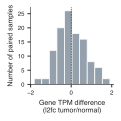

In [64]:
# using iso_id but this df is gene level
creb1_gene_diff = to_plot_brca_gene[to_plot_brca_gene["iso_id"] == "CREB1-1"][paired_diff_cols]
creb1_gene_diff = pd.melt(creb1_gene_diff)

fig = plt.figure(figsize=(1.5, 1.4))
ax = sns.histplot(data=creb1_gene_diff, x="value", color="slategrey")
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
ax.set_xlabel("Gene TPM difference\n(l2fc tumor/normal)")
ax.set_ylabel("Number of paired samples")

print(len(creb1_gene_diff[creb1_gene_diff["value"] < 0]))
print(len(creb1_gene_diff[creb1_gene_diff["value"] > 0]))
print(len(creb1_gene_diff))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/BRCA_CREB1_gene_diff_hist.pdf", dpi="figure", bbox_inches="tight")

## 8. import joung et al DEGs + target status

In [65]:
gfp_degs = {}
gfp_deg_dir = "%s/DEGs-LogFold_0.0_rawp-GFP" % deg_dir

for i, item in enumerate(os.listdir(gfp_deg_dir)):
    print(item)
    
    if item == "gene_summary.txt":
        continue
    
    df_path = os.path.join(gfp_deg_dir, item)
    df = pd.read_table(df_path)
    comp1 = item.split(".")[1].split("_")[0]
    comp2 = item.split(".")[1].split("_")[2]
    
    # focus on gfp for now
    if comp2 != "GFP":
        continue
        
    # find known tf targets
    gene_name = joung_map[joung_map["TF ORF"] == comp1]["gene_name"].iloc[0]
    tgts_sub = list(tf_tgts[tf_tgts["Symbol1"] == gene_name]["Symbol2"])
    
    if len(tgts_sub) == 0:
        df["known_target"] = False
        df["total_known_targets"] = 0
    else:
        df["known_target"] = df["Symbol"].isin(tgts_sub)
        df["total_known_targets"] = len(tgts_sub)
        
    df.columns = ["GeneID", "SystemCode", "LogFold", "rawp", "adjp", "Symbol", "avg-comp1", "avg-comp2",
                  "known_target", "total_known_targets"]
        
    gfp_degs[comp1] = df

GE.TFORF0517-PAX5_vs_GFP.txt
GE.TFORF2568-TGIF1_vs_GFP.txt
GE.TFORF2719-ZNF79_vs_GFP.txt
GE.TFORF3300-MEIS2_vs_GFP.txt
GE.TFORF2579-MEIS3_vs_GFP.txt
GE.TFORF2494-ZBTB18_vs_GFP.txt
GE.TFORF2980-FOXP3_vs_GFP.txt
GE.TFORF2580-MEIS3_vs_GFP.txt
GE.TFORF1328-TFAP2A_vs_GFP.txt
GE.TFORF2110-NR4A1_vs_GFP.txt
GE.TFORF0212-FOXP3_vs_GFP.txt
GE.TFORF3139-PPARG_vs_GFP.txt
GE.TFORF2996-TGIF1_vs_GFP.txt
GE.TFORF0495-EGR2_vs_GFP.txt
GE.TFORF3429-ZNF302_vs_GFP.txt
GE.TFORF0959-ERF_vs_GFP.txt
GE.TFORF0771-MSX2_vs_GFP.txt
GE.TFORF3313-ZBTB25_vs_GFP.txt
GE.TFORF1035-WT1_vs_GFP.txt
GE.TFORF3448-TP63_vs_GFP.txt
GE.TFORF1658-LEF1_vs_GFP.txt
GE.TFORF2815-FOSB_vs_GFP.txt
GE.TFORF0261-TCF4_vs_GFP.txt
GE.TFORF1452-DLX1_vs_GFP.txt
GE.TFORF3124-SMAD3_vs_GFP.txt
GE.TFORF1407-ZNF559_vs_GFP.txt
GE.TFORF1008-ZNF544_vs_GFP.txt
GE.TFORF2573-HSF2_vs_GFP.txt
GE.TFORF0373-NFYA_vs_GFP.txt
GE.TFORF3263-ZNF26_vs_GFP.txt
GE.TFORF0374-NFYA_vs_GFP.txt
GE.TFORF2574-HSF2_vs_GFP.txt
GE.TFORF2803-ETV2_vs_GFP.txt
GE.TFORF0820-LHX6_vs_

In [66]:
# load ref vs. alt degs
ref_degs = {}
ref_deg_dir = "%s/DEGs-LogFold_0.0_rawp-REF" % deg_dir

for i, item in enumerate(os.listdir(ref_deg_dir)):
    print(item)
    
    if item == "gene_summary.txt":
        continue
    
    df_path = os.path.join(ref_deg_dir, item)
    df = pd.read_table(df_path)
    comp1 = item.split(".")[1].split("_")[0]
    comp2 = item.split(".")[1].split("_")[2]
    
    # find known tf targets
    gene_name = joung_map[joung_map["TF ORF"] == comp1]["gene_name"].iloc[0]
    tgts_sub = list(tf_tgts[tf_tgts["Symbol1"] == gene_name]["Symbol2"])
    
    if len(tgts_sub) == 0:
        df["known_target"] = False
        df["total_known_targets"] = 0
    else:
        df["known_target"] = df["Symbol"].isin(tgts_sub)
        df["total_known_targets"] = len(tgts_sub)
        
    df.columns = ["GeneID", "SystemCode", "LogFold", "rawp", "adjp", "Symbol", "avg-comp1", "avg-comp2",
                  "known_target", "total_known_targets"]
        
    ref_degs[comp1] = df

GE.TFORF0374-NFYA_vs_TFORF0373-NFYA.txt
GE.TFORF0859-ZIC3_vs_TFORF3385-ZIC3.txt
GE.TFORF3299-MEIS2_vs_TFORF1935-MEIS2.txt
GE.TFORF0496-EGR2_vs_TFORF0495-EGR2.txt
GE.TFORF3244-ZNF483_vs_TFORF1222-ZNF483.txt
GE.TFORF0623-DDIT3_vs_TFORF3119-DDIT3.txt
GE.TFORF1957-ESR2_vs_TFORF1955-ESR2.txt
GE.TFORF0978-KLF7_vs_TFORF0979-KLF7.txt
GE.TFORF1142-HMBOX1_vs_TFORF1141-HMBOX1.txt
GE.TFORF2696-ELF5_vs_TFORF3109-ELF5.txt
GE.TFORF2973-PPARD_vs_TFORF1965-PPARD.txt
GE.TFORF1018-ZNF548_vs_TFORF1017-ZNF548.txt
GE.TFORF0959-ERF_vs_TFORF3527-ERF.txt
GE.TFORF1009-ZNF544_vs_TFORF3176-ZNF544.txt
GE.TFORF2633-TFDP2_vs_TFORF2637-TFDP2.txt
GE.TFORF3416-ZNF410_vs_TFORF2188-ZNF410.txt
GE.TFORF3178-TFDP2_vs_TFORF2637-TFDP2.txt
GE.TFORF0970-ZNF124_vs_TFORF0973-ZNF124.txt
GE.TFORF0999-ZNF302_vs_TFORF3429-ZNF302.txt
GE.TFORF3275-HMGA1_vs_TFORF3274-HMGA1.txt
GE.TFORF0314-CREM_vs_TFORF0301-CREM.txt
GE.TFORF1167-EBF3_vs_TFORF3271-EBF3.txt
GE.TFORF0825-LHX8_vs_TFORF0824-LHX8.txt
GE.TFORF3304-MITF_vs_TFORF3303-MITF.txt
GE

In [67]:
tgts_dict = {}
n_degs_df = {}

for iso in ref_degs:
    refvsalt_df = ref_degs[iso]
    refvsalt_df["neglog_adjp"] = -np.log10(refvsalt_df["adjp"])
    refvsalt_df = refvsalt_df.merge(oncots_mrg, left_on="Symbol", right_on="gene_name",
                                    how="left")
    
    # now get the ref iso degs
    gene = joung_map[joung_map["TF ORF"] == iso]["gene_name"].iloc[0]
    ref_iso = joung_map[(joung_map["gene_name"] == gene) &
                        (joung_map["dn_cat"] == "ref")]["TF ORF"].iloc[0]
    gfp_df = gfp_degs[ref_iso]
    
    full_df = refvsalt_df.merge(gfp_df[["GeneID", "Symbol", "LogFold", "adjp"]], on=["GeneID", "Symbol"],
                                how="left", suffixes=("_vs", "_ref_vs_gfp"))
    
    altgfp_df = gfp_degs[iso]
    altgfp_df = altgfp_df[["GeneID", "Symbol", "LogFold", "adjp"]]
    altgfp_df.columns = ["GeneID", "Symbol", "LogFold_alt_vs_gfp", "adjp_alt_vs_gfp"]
    full_df = full_df.merge(altgfp_df, on=["GeneID", "Symbol"],
                            how="left")
    
    
    
    tgts_dict[iso] = full_df
    
    # summary stats
    n_degs = len(full_df[(full_df["adjp_vs"] < 0.05)])
    n_tgts = len(full_df[(full_df["known_target"] == True)])
    n_deg_tgts = len(full_df[(full_df["adjp_vs"] < 0.05) & (full_df["known_target"] == True)])
    n_degs_df[iso] = {"n_degs": n_degs, "n_tgts": n_tgts, "n_deg_tgts": n_deg_tgts}

In [68]:
n_degs_df = pd.DataFrame.from_dict(n_degs_df, orient="index").reset_index()
n_degs_df["pct_tgts_deg"] = (n_degs_df["n_deg_tgts"]/n_degs_df["n_tgts"])*100
n_degs_df[n_degs_df["index"].str.contains("CREB1")]

,index,n_degs,n_tgts,n_deg_tgts,pct_tgts_deg
41,TFORF3026-CREB1,8158,190,83,43.684211


In [69]:
print("TOT # REF/ALT PAIRS: %s" % len(n_degs_df))
print("AVG # DEGs: %s" % (n_degs_df.n_degs.mean()))
print("MEDIAN # DEGs: %s" % (n_degs_df.n_degs.median()))
print("NUM REF/ALT PAIRS WITH ≥100 DEGs: %s" % (len(n_degs_df[n_degs_df["n_degs"] >= 100])))

TOT # REF/ALT PAIRS: 120
AVG # DEGs: 3042.366666666667
MEDIAN # DEGs: 2027.5
NUM REF/ALT PAIRS WITH ≥100 DEGs: 97


## 8. plot CREB1 DEGs

In [70]:
creb1 = tgts_dict["TFORF3026-CREB1"]
creb1_sub = creb1[creb1["known_target"] == True]
creb1_sub["cancer_status"].fillna("none", inplace=True)

In [71]:
cancer_pal = {"Oncogene": "hotpink",
              "Tumor Suppressor": "darkorange",
              "Cancer-associated": "rosybrown",
              "none": "lightgrey"}

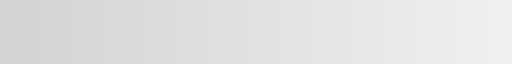

In [72]:
cmap = sns.light_palette("lightgrey", reverse=True, as_cmap=True)
cmap

AHCYL1
SMCHD1
LAPTM4B
NUP98
NF1


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


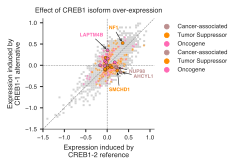

In [73]:
fig = plt.figure(figsize=(2, 2))

ax = sns.histplot(data=creb1, x="LogFold_ref_vs_gfp", y="LogFold_alt_vs_gfp", bins=50,
                  cmap=cmap)
sns.scatterplot(data=creb1[(creb1["cancer_status"].isin(["Oncogene", "Tumor Suppressor", "Cancer-associated"])) &
                           (creb1["adjp_vs"] < 0.05)], 
                x="LogFold_ref_vs_gfp", y="LogFold_alt_vs_gfp", ax=ax, s=5, alpha=0.5,
                hue="cancer_status", palette=cancer_pal)

sns.scatterplot(data=creb1[(creb1["cancer_status"].isin(["Oncogene", "Tumor Suppressor", "Cancer-associated"])) &
                           (creb1["adjp_vs"] < 0.05) &
                           (creb1["known_target"] == True)], 
                x="LogFold_ref_vs_gfp", y="LogFold_alt_vs_gfp", ax=ax, s=10, alpha=1,
                hue="cancer_status", palette=cancer_pal, edgecolor="black")

ax.set_xlabel("Expression induced by\nCREB1-2 reference")
ax.set_ylabel("Expression induced by\nCREB1-1 alternative")
plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)
ax.set_xlim((-1.5, 1.1))
ax.set_ylim((-1.5, 1.1))
ax.plot([-1.5, 1.1], [-1.5, 1.1], color="gray", linestyle="dashed", linewidth=0.5)
ax.axhline(y=0, color="gray", linestyle="dashed", linewidth=0.5)
ax.axvline(x=0, color="gray", linestyle="dashed", linewidth=0.5)

# labels
sub = creb1[(creb1["cancer_status"].isin(["Oncogene", "Tumor Suppressor", "Cancer-associated"])) &
            (creb1["adjp_vs"] < 0.05) & (creb1["known_target"] == True) &
            ((creb1["LogFold_ref_vs_gfp"] > 0.2) | (creb1["LogFold_alt_vs_gfp"] > 0.2))]
# sub2 = creb1[creb1["Symbol"] == "KDM5B"]
# sub = pd.concat([sub, sub2])


offsets = [(0.3, -0.1), (0.05, -0.4), (-0.1, 0.3), (0.3, -0.1), (-0.1, 0.3), (0.3, 0)]
havas = [("left", "center"), ("center", "top"), ("right", "bottom"), ("left", "center"), ("right", "bottom"),
         ("left", "center")]
c = 0
for i, row in sub.iterrows():
    print(row['Symbol'])
    offset = offsets[c]
    hava = havas[c]
    cs = row["cancer_status"]
    if cs == "none":
        color = "grey"
    else:
        color = cancer_pal[cs]
    text = plt.annotate(row["Symbol"], xy=(row["LogFold_ref_vs_gfp"], row["LogFold_alt_vs_gfp"]), 
                    xytext=(row["LogFold_ref_vs_gfp"]+offset[0], row["LogFold_alt_vs_gfp"]+offset[1]), 
                    ha=hava[0], va=hava[1],
                    fontsize=PAPER_FONTSIZE-2, color=color,
                    zorder=100, fontweight="bold", arrowprops=dict(arrowstyle='->',
                                                                   color='black', linewidth=0.5),
                     bbox=dict(pad=0.1, facecolor='none', edgecolor='none'))
    c += 1
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Effect of CREB1 isoform over-expression")
fig.savefig("../../figures/fig7/CREB1_joung_scatter.all_genes_pq.pdf", dpi="figure", bbox_inches="tight")

## 9. heatmap of gene set enrichments

In [74]:
grns = grns_up.merge(grns_down, on="Comparison (pairwise)", suffixes=("_up", "_down"))

In [75]:
print(len(grns))
grns = grns.merge(joung_map, left_on="ALTERNATIVE_up", right_on="TF ORF")
grns["dn_cat"] = grns["dn_cat"].fillna("NA")
print(len(grns))

120
120


In [76]:
# one-sided p-val of 0.05 is a z-score of 1.645
grns_sig = grns[(grns["Oncogene_up"] >= 1.645) |
                (grns["Oncogene.1_up"] >= 1.645) |
                (grns["Oncogene_down"] >= 1.645) |
                (grns["Oncogene.1_down"] >= 1.645) |
                (grns["Tumor Suppressor_up"] >= 1.645) |
                (grns["Tumor Suppressor.1_up"] >= 1.645) |
                (grns["Tumor Suppressor_down"] >= 1.645) |
                (grns["Tumor Suppressor.1_down"] >= 1.645)]
len(grns_sig)

114

In [77]:
sig_cancer = pancan[pancan['sig_status_simple'] == 'sig. in ≥1']
grns_filt = grns_sig[grns_sig['tf1p0_id'].isin(sig_cancer['clone_acc'])]
grns_filt = grns_filt.merge(pancan[['clone_acc', 'isoform', 'sig_status_simple', 'directionality']],
                            left_on='tf1p0_id', right_on='clone_acc')
print(len(grns_filt))

62


In [78]:
elitego_cols = ['Mitotic M-M/G1 phases_up', 'S Phase_up', 'Tumor Suppressor_up',
                'Mitotic G2-G2/M phases_up', 'Oncogene_up', 'Mitotic M-M/G1 phases.1_up', 'S Phase.1_up',
                'Tumor Suppressor.1_up', 'Mitotic G2-G2/M phases.1_up', 'Oncogene.1_up',
                'Mitotic M-M/G1 phases_down', 'S Phase_down', 'Tumor Suppressor_down', 
                'Mitotic G2-G2/M phases_down', 'Oncogene_down', 'Mitotic M-M/G1 phases.1_down', 'S Phase.1_down',
                'Tumor Suppressor.1_down', 'Mitotic G2-G2/M phases.1_down',
                'Oncogene.1_down']

In [79]:
grns_filt = grns_filt.merge(oncots_mrg, left_on="gene_name", right_on="gene_name", how="left")

In [80]:
dn_pal = {"ref": sns.color_palette("Set2")[0],
          "similar to ref.": sns.color_palette("Set2")[0],
          "similar": sns.color_palette("Set2")[0],
          "rewirer": sns.color_palette("Set2")[2],
          "rewire": sns.color_palette("Set2")[2],
          "negative regulator": sns.color_palette("Set2")[1],
          "DN": sns.color_palette("Set2")[1],
          "NA": "lightgray",
          "likely non-functional": "darkgray"}

In [81]:
# calculate diffs only when at least 1 of the 2 paired columns is significantly enriched
grns_filt['Oncogene_up_diff'] = np.where((grns_filt['Oncogene_up'] >= 1.645) | 
                                         (grns_filt['Oncogene.1_up'] >= 1.645),
                                          grns_filt['Oncogene_up'] - grns_filt['Oncogene.1_up'],
                                          np.nan)
grns_filt['Tumor Suppressor_up_diff'] = np.where((grns_filt['Tumor Suppressor_up'] >= 1.645) | 
                                         (grns_filt['Tumor Suppressor.1_up'] >= 1.645),
                                          grns_filt['Tumor Suppressor_up'] - grns_filt['Tumor Suppressor.1_up'],
                                          np.nan)
grns_filt['Oncogene_down_diff'] = np.where((grns_filt['Oncogene_down'] >= 1.645) | 
                                         (grns_filt['Oncogene.1_down'] >= 1.645),
                                          grns_filt['Oncogene_down'] - grns_filt['Oncogene.1_down'],
                                          np.nan)
grns_filt['Tumor Suppressor_down_diff'] = np.where((grns_filt['Tumor Suppressor_down'] >= 1.645) | 
                                         (grns_filt['Tumor Suppressor.1_down'] >= 1.645),
                                          grns_filt['Tumor Suppressor_down'] - grns_filt['Tumor Suppressor.1_down'],
                                          np.nan)

In [82]:
grns_filt["cancer_status"].fillna("none", inplace=True)

In [83]:
cancer_pal = {"Oncogene": "hotpink",
              "Tumor Suppressor": "gold",
              "Cancer-associated": "rosybrown",
              "none": "ghostwhite"}

In [84]:
# filter to those with at least 2-fold enrichment
to_plot = grns_filt[(grns_filt["Oncogene_up"] >= 1.645) |
                    (grns_filt["Oncogene.1_up"] >= 1.645) |
                    (grns_filt["Tumor Suppressor_up"] >= 1.645) |
                    (grns_filt["Tumor Suppressor.1_up"] >= 1.645) ]


row_colors1 = to_plot.set_index("ALTERNATIVE_up").dn_cat.map(dn_pal)
row_colors2 = to_plot.set_index("ALTERNATIVE_up").cancer_status.map(cancer_pal)


to_plot = to_plot[["ALTERNATIVE_up", "Oncogene_up_diff", 
                   "Oncogene_down_diff", "Tumor Suppressor_up_diff", 
                   "Tumor Suppressor_down_diff"]].set_index("ALTERNATIVE_up").T
to_plot.fillna(-10, inplace=True)
print(to_plot.shape)
print(to_plot.min().min())

(4, 61)
-10.0


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


['CREB1-1' 'PBX1-2' 'PKNOX1-3' 'MAX-5' 'SMAD3-3' 'NR4A1-1']


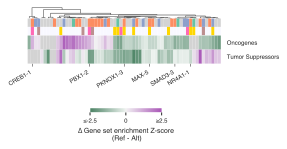

In [85]:
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
cmap.set_under(color='lightgrey')

g = sns.clustermap(data=to_plot.loc[["Oncogene_up_diff", 
                                     "Tumor Suppressor_up_diff"]], cmap=cmap, linewidth=0, 
                   figsize=(4, 2.1), xticklabels=True,
                   yticklabels=True,
                   center=0, vmin=-2.5, vmax=2.5, dendrogram_ratio=(0, 0.2),
                   metric='euclidean', method='complete',
                   row_cluster=False, row_linkage=None,
                   cbar_pos=(0.25, 0.25, 0.25, 0.03), 
                   cbar_kws={"label": "∆ Gene set enrichment Z-score\n (Ref - Alt)",
                             "orientation": "horizontal",
                             "ticks": [-2.5, 0, 2.5]},
                   col_colors=[row_colors1, row_colors2], colors_ratio=0.15)

_ = g.cax.set_xticklabels(["≤-2.5", "0", "≥2.5"])
g.ax_col_colors.set_yticks([])
g.ax_col_colors.set_xticks([])
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_yticklabels(('Oncogenes', 'Tumor Suppressors'))
g.ax_heatmap.tick_params(right=False)

# label specific genes
use_labels = list(grns_filt[(grns_filt['cancer_status'].isin(["Oncogene", "Tumor Suppressor"])) &
                            (grns_filt['dn_cat'] == 'DN')]["ALTERNATIVE_up"]) + ['TFORF0115-SMAD3']
reordered_labels = to_plot.columns[g.dendrogram_col.reordered_ind].tolist()
use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
new_names = [grns_filt[grns_filt['ALTERNATIVE_up'] == x]['isoform'].iloc[0] for x in use_labels]
g.ax_heatmap.set(xticks=use_ticks, xticklabels=new_names)
g.ax_heatmap.set_xticklabels(new_names, rotation=30, va='top', ha='right')
g.ax_heatmap.xaxis.set_tick_params(width=0.5)

# print the labels to make more clear in illustrator
idx = np.argsort(use_ticks)
print(np.asarray(new_names)[idx])

g.savefig("../../figures/fig7/EliteGo_Heatmap.Ref_Minus_Alt.filtered.pdf", dpi="figure", bbox_inches="tight")

## 10. write supplemental files

In [86]:
# supp table: paired samples used in TCGA analysis
supp_brcasamps = paired_dfs["BRCA"][["tcga_id_ctrl", "tcga_id_tumor"]]
supp_brcasamps["cancer_type"] = "BRCA"
supp_luadsamps = paired_dfs["LUAD"][["tcga_id_ctrl", "tcga_id_tumor"]]
supp_luadsamps["cancer_type"] = "LUAD"
supp_hnsccsamps = paired_dfs["HNSCC"][["tcga_id_ctrl", "tcga_id_tumor"]]
supp_hnsccsamps["cancer_type"] = "HNSCC"
supp_tcgasamps = pd.concat([supp_brcasamps, supp_luadsamps, supp_hnsccsamps])
supp_tcgasamps.cancer_type.value_counts()

cancer_type
BRCA     112
LUAD     105
HNSCC     43
Name: count, dtype: int64

In [87]:
supp_tcgasamps.to_csv("../../supp/SuppTable_TCGASamps.txt", sep="\t", index=False)

In [88]:
# supp table: TCGA results for cloned isoforms
supp_tcgares = pancan_lib[["isoform", 'mean_tumor_iso_pct_brca', 'mean_normal_iso_pct_brca',
       'mean_iso_pct_diff_brca', 'pval_brca', 'n_samps_brca', 'padj_brca',
       'mean_tumor_iso_pct_luad', 'mean_normal_iso_pct_luad',
       'mean_iso_pct_diff_luad', 'pval_luad', 'n_samps_luad', 'padj_luad',
       'mean_tumor_iso_pct_hnscc', 'mean_normal_iso_pct_hnscc',
       'mean_iso_pct_diff_hnscc', 'pval_hnscc', 'n_samps_hnscc', 'padj_hnscc']]
len(supp_tcgares)

613

In [89]:
supp_tcgares.to_csv("../../supp/SuppTable_TCGAResults.txt", sep="\t", index=False)

In [90]:
# supp table: joung et al summary
supp_joung = grns[['REFERENCE_up', 'ALTERNATIVE_up', 'Oncogene_up',
                   'Oncogene.1_up', 'Tumor Suppressor_up', 'Tumor Suppressor.1_up',
                   'Oncogene_down', 'Oncogene.1_down', 'Tumor Suppressor_down',
                   'Tumor Suppressor.1_down']]
supp_joung.columns = ['ref_iso_morf_id', 'alt_iso_morf_id', 'oncogene_ref_up',
                      'oncogene_alt_up', 'ts_ref_up', 'ts_alt_up',
                      'oncogene_ref_down', 'oncogene_alt_down', 'ts_ref_down',
                      'ts_alt_down']
supp_joung = n_degs_df.merge(supp_joung, left_on='index', right_on='alt_iso_morf_id')
supp_joung = supp_joung.merge(joung_map[['TF ORF', 'tf1p0_id']], left_on='index',
                              right_on='TF ORF')

def format_id(row):
    return row['tf1p0_id'].split("|")[0] + '-' + row['tf1p0_id'].split("|")[1].split("/")[0]

supp_joung['alt_iso'] = supp_joung.apply(format_id, axis=1)
supp_joung = supp_joung[['alt_iso', 'ref_iso_morf_id', 'alt_iso_morf_id', 
                         'n_degs', 'n_tgts', 'n_deg_tgts', 'pct_tgts_deg',
                         'oncogene_ref_up', 'oncogene_alt_up', 'ts_ref_up', 'ts_alt_up',
                         'oncogene_ref_down', 'oncogene_alt_down', 'ts_ref_down', 'ts_alt_down']]
supp_joung[supp_joung['alt_iso'].str.contains('CREB1')]

,alt_iso,ref_iso_morf_id,alt_iso_morf_id,n_degs,n_tgts,n_deg_tgts,pct_tgts_deg,oncogene_ref_up,oncogene_alt_up,ts_ref_up,ts_alt_up,oncogene_ref_down,oncogene_alt_down,ts_ref_down,ts_alt_down
41,CREB1-1,TFORF2364-CREB1,TFORF3026-CREB1,8158,190,83,43.684211,2.053514,1.034273,0.997905,-0.443583,-0.810777,-1.752386,-3.069581,-1.162003


In [91]:
supp_joung.to_csv("../../supp/SuppTable_JoungResults.txt", sep="\t", index=False)

# create TCGA plots for website
takes a while so comment out when done

In [92]:
def paired_swarmplot(df, iso_id, cancer, padj, l2fc, fig_filename):
    fig = plt.figure(figsize=(1.5, 1.5))

    sub_melt = df[(df["iso_id"] == iso_id)]
    
    # only include vals which are not NA in both tumor and normal
    norm_nonan = list(sub_melt[(sub_melt['samp'] == 'normal') &
                          ~(pd.isnull(sub_melt['value']))]['patient'])
    tumor_nonan = list(sub_melt[(sub_melt['samp'] == 'tumor') &
                          ~(pd.isnull(sub_melt['value']))]['patient'])
    norm_tumor_nonan = list(set(norm_nonan).intersection(set(tumor_nonan)))
    sub_melt = sub_melt[sub_melt['patient'].isin(norm_tumor_nonan)]
    
    sub_melt = sub_melt.sort_values(by=['samp', 'patient'])
    if len(sub_melt) == 0:
        return None

    ax = sns.swarmplot(data=sub_melt, x="samp", y="value", s=2,
                       palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]},
                       alpha=0.75, linewidth=0.5, edgecolor="black",
                       order=["normal", "tumor"])


    norm_paths = ax.collections[0].get_offsets()
    norm_x, norm_y = norm_paths[:, 0], norm_paths[:, 1]

    tumor_paths = ax.collections[1].get_offsets()
    tumor_x, tumor_y = tumor_paths[:, 0], tumor_paths[:, 1]

    for i in range(norm_x.shape[0]):
        x = [norm_x[i], tumor_x[i]]
        y = [norm_y[i], tumor_y[i]]
        ax.plot(x, y, linestyle="dashed", color="darkgrey", linewidth=0.25)

    # add padj + l2fc to title
    ax.set_title("%s in paired %s samples\npadj: %s | mean l2fc: %s" % (iso_id, cancer, padj, l2fc))
    

    ax.set_xlabel("")
    
    # set the ylimits based on the max/min value
    max_val = sub_melt['value'].max()
    yceil = math.ceil(max_val * 10) / 10
    
    min_val = sub_melt['value'].min()
    yfloor = math.floor(min_val * 10)/10
    if yfloor == 0:
        yfloor = -0.01

    ax.set_ylim((yfloor, yceil))
    
    if yfloor == -0.01:
        yticks = np.linspace(0, yceil, 5)
    else:
        yticks = np.linspace(yfloor, yceil, 5)
        
    ax.set_yticks(yticks)
    ax.set_yticklabels(["%s%%" % int(x*100) for x in yticks])
    ax.set_ylabel("Isoform percentage\nof gene expression")

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    fig.savefig(fig_filename, dpi="figure", bbox_inches="tight")
    plt.close()
    return fig

In [93]:
def format_number(num):
    if abs(num) < 0.001 and num != 0:
        return f"{num:.1e}"  # Format in scientific notation
    else:
        return f"{num:.3f}"  # Otherwise, return as a float with 2 decimal places

In [94]:
# for cancer in ['BRCA', 'LUAD', 'HNSCC']:
#     print(cancer)
#     tcga = res_dfs[cancer].reset_index()
#     tcga["gene_name"] = tcga.iso_id.map(gene_dict)
    
#     paired_df = paired_dfs[cancer]
#     paired_ctrls = list(paired_df["tcga_id_ctrl"])
#     paired_tumors = list(paired_df["tcga_id_tumor"])
    
#     tcga = tcga[["gene_name", "iso_id"] + paired_ctrls + paired_tumors]
#     new_ctrl_cols = ["normal - %s" % (i+1) for i, x in enumerate(paired_ctrls)]
#     new_tumor_cols = ["tumor - %s" % (i+1) for i, x in enumerate(paired_tumors)]
#     tcga.columns = ["gene_name", "iso_id"] + new_ctrl_cols + new_tumor_cols
    
#     tcga_melt = pd.melt(tcga, id_vars=["gene_name", "iso_id"])
#     tcga_melt["samp"] = tcga_melt["variable"].str.split(" ", expand=True)[0]
#     tcga_melt["patient"] = tcga_melt["variable"].str.split(" - ", expand=True)[1].astype(int)
    
#     # now plot per iso
#     for i, row in pancan_lib.iterrows():
#         print('  %s' % row.iso_id)
#         iso_id = row.iso_id
#         gene_name = row.gene_name
#         padj = format_number(row['padj_%s' % cancer.lower()])
#         l2fc = format_number(row["mean_iso_pct_diff_%s" % cancer.lower()])
#         fig_dir = "../../figures/for_website/tcga/%s" % gene_name
        
#         !mkdir -p $fig_dir
        
#         fig_filename = "%s/%s.%s.pdf" % (fig_dir, iso_id, cancer)
#         _ = paired_swarmplot(tcga_melt, iso_id, cancer, padj, l2fc, fig_filename)